# Checking if scyan is installed

In [12]:
try:
    import scyan
    print("scyan is installed.")
except ImportError:
    print("scyan is not installed. Installing now...")
    !pip install scyan

scyan is installed.


In [11]:
import anndata
from pathlib import Path
import pandas as pd
import time
import matplotlib.pyplot as plt

# Concaténation de fichier FSC (WT1)

In [3]:
# Folder path
folder_path = Path(r"C:/Users/anush/Desktop/M1 BME/S2/stage/fcs_data/WT-6 PRE")

# Load the FCS files
fcs_paths = [path for path in folder_path.iterdir() if path.suffix == ".fcs"]

def read_one(path):
    adata_WT6_PRE = scyan.read_fcs(path)
    adata_WT6_PRE.obs["file"] = path.stem
    adata_WT6_PRE.obs["batch"] = "NA"
    return adata_WT6_PRE

adata_WT6_PRE = anndata.concat([read_one(p) for p in fcs_paths], index_unique="-")

# Preprocessing 

In [4]:
# Preprocessing
is_cytof = True
if is_cytof:
    scyan.preprocess.asinh_transform(adata_WT6_PRE)
else:
    scyan.preprocess.auto_logicle_transform(adata_WT6_PRE)

scyan.preprocess.scale(adata_WT6_PRE)

[INFO] (scyan.preprocess) Data will be standardised, and translated so that 0 goes to -1. This is advised only when using CyTOF data (if this is not your case, consider running 'auto_logicle_transform' instead of 'asinh_transform').


# Knowledge table

In [5]:
file_path = 'C:/Users/anush/Desktop/M1 BME/S2/stage/Report/Table_ref_V2.csv'
table = pd.read_csv(file_path, index_col=[0, 1])

# Sanity check

In [6]:
# Check for missing markers and duplicates
missing_markers = [col for col in table.columns if col not in adata_WT6_PRE.var_names]
if missing_markers:
    print("Markers in table.columns not present in adata_WT6_PRE.var_names:")
    print(missing_markers)
else:
    print("All markers in table.columns are present in adata_WT6_PRE.var_names.")

All markers in table.columns are present in adata_WT6_PRE.var_names.


# Duplicate checking

In [7]:
# Check for duplicate rows based on the markers expression
duplicates = table[table.duplicated(keep=False)]

if not duplicates.empty:
    print("Duplicate rows found based on marker expressions:")
    print(duplicates)
else:
    print("No duplicates found based on marker expressions.")

No duplicates found based on marker expressions.


# Timepoint function

In [8]:
# Map time points and treatments
def map_time_point(filename):
    parts = filename.split('_')
    if len(parts) >= 2:
        day = parts[1]  # Extract day (e.g., "Day0", "Day7", "Day10")
        return day
    return 'Unknown'

def map_treatment(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        treatment = parts[2]  # Extract treatment if available
        return treatment
    return 'None'

adata_WT6_PRE.obs["time_point"] = adata_WT6_PRE.obs["file"].map(map_time_point)
adata_WT6_PRE.obs["treatment"] = adata_WT6_PRE.obs["file"].map(map_treatment)

adata_WT6_PRE.obs["time_point"] = pd.Categorical(
    adata_WT6_PRE.obs["time_point"],
    categories=["Day0", "Day7", "Day10"],
    ordered=True
)

print("Unique time points (with order):")
print(adata_WT6_PRE.obs["time_point"].unique())
print("Unique treatments:")
print(adata_WT6_PRE.obs["treatment"].unique())

print(adata_WT6_PRE.obs.head(8))


Unique time points (with order):
['Day0', 'Day10', 'Day7']
Categories (3, object): ['Day0' < 'Day7' < 'Day10']
Unique treatments:
['None' 'DMSO' 'G10' 'G25' 'G50']
     Time     SSC-H        SSC-A     FSC-H         FSC-A   SSC-B-H  \
0-0   0.0  334596.0  542821.1250  756412.0  1.134577e+06  175882.0   
1-0   5.0  418780.0  897467.7500  999161.0  1.821199e+06  248745.0   
2-0  15.0  357872.0  575906.5625  628426.0  9.318459e+05  235069.0   
3-0  15.0  384663.0  617289.1250  561947.0  8.445884e+05  229067.0   
4-0  25.0  564687.0  655916.1250  434254.0  4.968784e+05  360272.0   
5-0  35.0  313896.0  523653.9375  453841.0  6.953911e+05  144662.0   
6-0  53.0  306820.0  454736.8125  708700.0  1.023448e+06  182912.0   
7-0  60.0  355615.0  615972.8125  467964.0  7.436942e+05  208113.0   

          SSC-B-A          PU1         CEBPA         GATA2     Dead cells  \
0-0  265958.50000 -1426.921387   6763.950684   4936.239746    4000.584229   
1-0  519418.46875   630.197571  15756.512695  16078

# UMAP

In [9]:
start_time = time.time()
scyan.tools.umap(adata_WT6_PRE, markers=table.columns)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps écoulé pour le calcul de l'UMAP : {elapsed_time:.2f} secondes")

[INFO] (scyan.tools.representation) Fitting UMAP...


Temps écoulé pour le calcul de l'UMAP : 409.44 secondes


# Saving the Scyan Project

In [11]:
scyan.data.add("WT6_PRE", adata_WT6_PRE, table)

[INFO] (scyan.data.datasets) Creating new dataset folder at C:\Users\anush\.scyan_data\WT6_PRE
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\WT6_PRE\default.h5ad
[INFO] (scyan.data.datasets) Created file C:\Users\anush\.scyan_data\WT6_PRE\default.csv


# Loading the Scyan project

In [2]:
adata_WT6_PRE, table = scyan.data.load("WT6_PRE")

# Model fitting

In [5]:
# Initialize and fit model
model_WT6_PRE = scyan.Scyan(adata_WT6_PRE, table)
model_WT6_PRE.fit()

[INFO] (scyan.model) Initialized Scyan model with N=2883828 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5
"warm_up":         (0.35, 4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params | Mode 
-----------------------------------------------
0 | module | ScyanModule | 34.6 K | train
-----------------------------------------------
34.6 K    Trainable params
0         Non-trainable params
34.6 K    Total params
0.139     Total estimated model params size (MB)
243       Modules in train mode
0         

Training: |                                                                                      | 0/? [00:00<…

[INFO] (scyan.model) Ended warm up epochs
[INFO] (scyan.model) Successfully ended training.


Scyan model with N=2883828 cells, P=28 populations and M=25 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False

# 1st prediction

In [6]:
model_WT6_PRE.predict()

DataLoader:   0%|          | 0/353 [00:00<?, ?it/s]

[WARNING] (scyan.model) 8 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


0          Granulocytes
1          Granulocytes
2          Granulocytes
3          Granulocytes
4                   NaN
               ...     
2883823             NaN
2883824    Granulocytes
2883825    Granulocytes
2883826    Granulocytes
2883827    Granulocytes
Length: 2883828, dtype: category
Categories (20, object): [' CD45RA+ Memory Effector T cell', 'Basophils', 'CD11B+_Monocytes*', 'CD34+CD38+CD123+ HSPCs', ..., 'Plasma B', 'Promonocytes', 'Transitional & Memory effector T cell', 'pDC']

# Checking the threshold

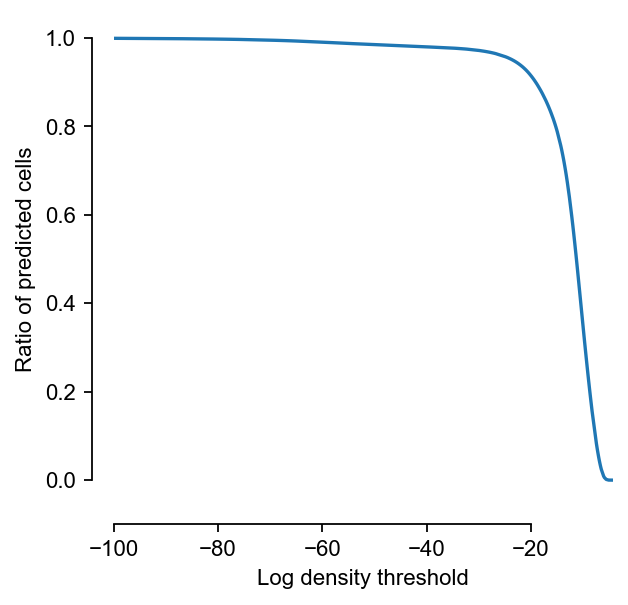

In [7]:
# Log probability threshold plot
scyan.plot.log_prob_threshold(adata_WT6_PRE)

# UMAP visualization

In [8]:
# Predict cell populations
threshold = -30
model_WT6_PRE.predict(log_prob_th=threshold)
print(f"Prediction performed with log probability threshold set to: {threshold}")

DataLoader:   0%|          | 0/353 [00:00<?, ?it/s]

[WARNING] (scyan.model) 8 population(s) were not predicted. It may be due to:
  - Errors in the knowledge table (see https://mics-lab.github.io/scyan/advice/#advice-for-the-creation-of-the-table)
  - The model hyperparameters choice (see https://mics-lab.github.io/scyan/advanced/parameters/)
  - Or maybe these populations are really absent from this dataset.


Prediction performed with log probability threshold set to: -30


# Palette

In [9]:
# Define the color palettes for UMAP visualization
# Define the updated unique color palette for UMAP visualization
color_palette = {
    'LSC_CD34+_CD117+': '#D9534F',         # Red
    'LSC_CD34+_CD117-': '#C8102E',         # Dark Red
    'LSC_CD34-_CD117+': '#B02E26',         # Crimson
    'LSC_CD34-_CD117-': '#A7322A',         # Dark Crimson
    'HSC_CD117+': '#1E88E5',               # Blue
    'HSC_CD117-': '#1976D2',               # Dark Blue
    'CD34+CD38+CD123+ HSPCs': '#66BB6A',   # Light Green
    'CMP': '#4CAF50',                      # Green
    'MEP': '#43A047',                      # Dark Green
    'GMP': '#388E3C',                      # Olive Green
    'pDC': '#5C6BC0',                     # Medium Blue
    'NK': '#26A69A',                      # Teal
    'NK-CD62L-': '#004D40',               # Dark Teal
    'B cells': '#FFCA28',                 # Yellow
    'Plasma B': '#FFB300',                # Amber
    'Granulocytes': '#90A4AE',            # Grey
    'Basophils': '#78909C',               # Blue Grey
    'Naive T cells': '#AB47BC',           # Purple
    'CD45RA+ Memory Effector T cell': '#9C27B0', # Dark Purple
    'Central Memory T cell': '#8E24AA',   # Medium Purple
    'Transitional & Memory effector T cell': '#7B1FA2', # Deep Purple
    'Erythrocytes_CD45+': '#E57373',      # Light Coral
    'Erythrocytes_CD45-': '#F44336',      # Red
    'CD11B+_Monocytes': '#BCAAA4',        # Light Brown
    'CD11B+_Monocytes*': '#A1887F',       # Medium Brown
    'Promonocytes': '#D7CCC8',            # Beige
    'Mono_Myeloblastes_CD15+': '#7CB342', # Olive Drab
    'Mono_Myeloblastes_CD15-': '#9CCC65', # Light Olive
}

# Define the updated hierarchical color palette
hierarchy_palette = {
    'LSC': '#D9534F',                    # Red
    'HSC': '#1E88E5',                    # Blue
    'Progenitors': '#66BB6A',            # Light Green
    'Dendritic': '#5C6BC0',              # Medium Blue
    'NK': '#26A69A',                    # Teal
    'B Cells': '#FFCA28',               # Yellow
    'Myeloid': '#90A4AE',               # Grey
    'T Cells': '#AB47BC',               # Purple
    'Erythrocytes': '#E57373',          # Light Coral
    'Monocytes': '#BCAAA4',             # Light Brown
    'NKCD62L-': '#004D40',              # Dark Teal
}

# UMAP level plotting

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


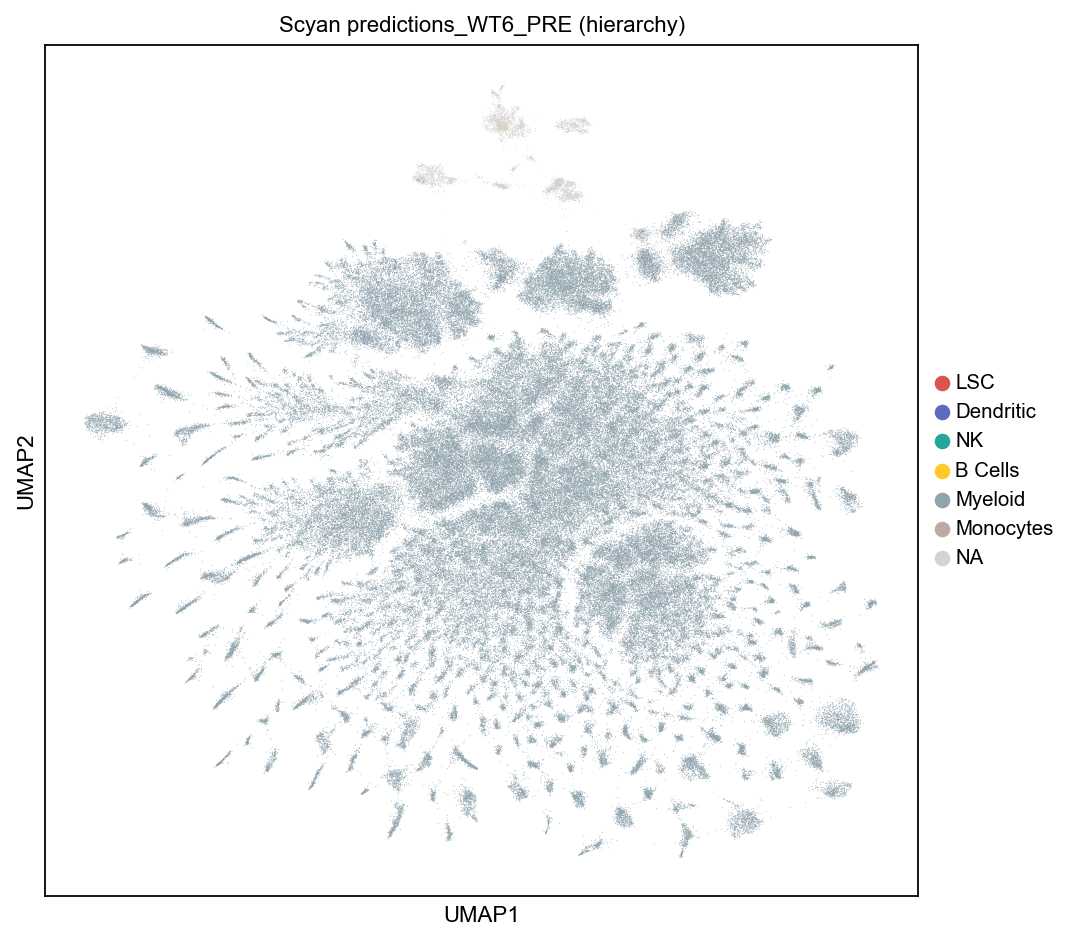

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_WT6_PRE, color="scyan_pop_level", ax=ax, title="Scyan predictions_WT6_PRE (hierarchy)", palette=hierarchy_palette)
plt.show() 

# UMAP plotting (normal)

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


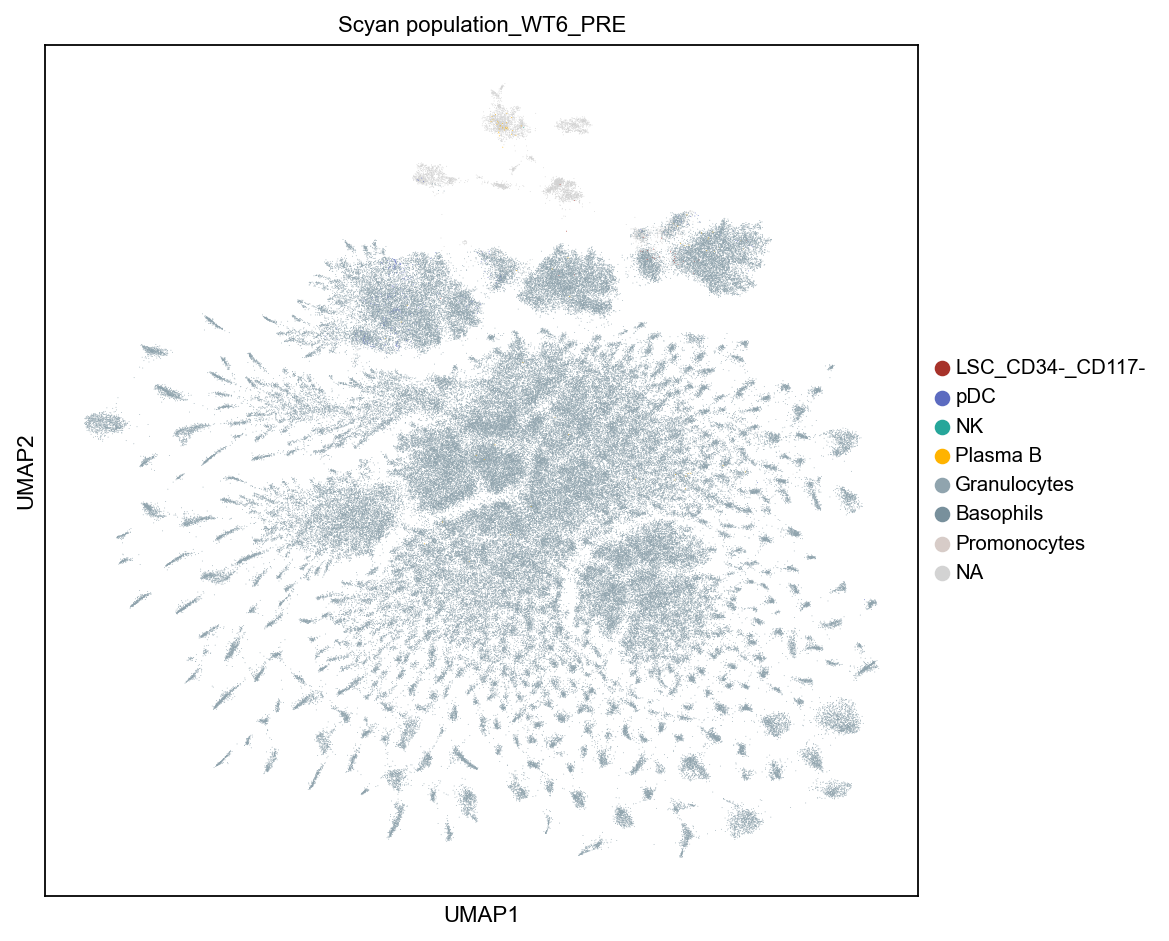

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
scyan.plot.umap(adata_WT6_PRE, color="scyan_pop", ax=ax, title="Scyan population_WT6_PRE", palette=color_palette)
plt.show()

# UMAP for each file

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


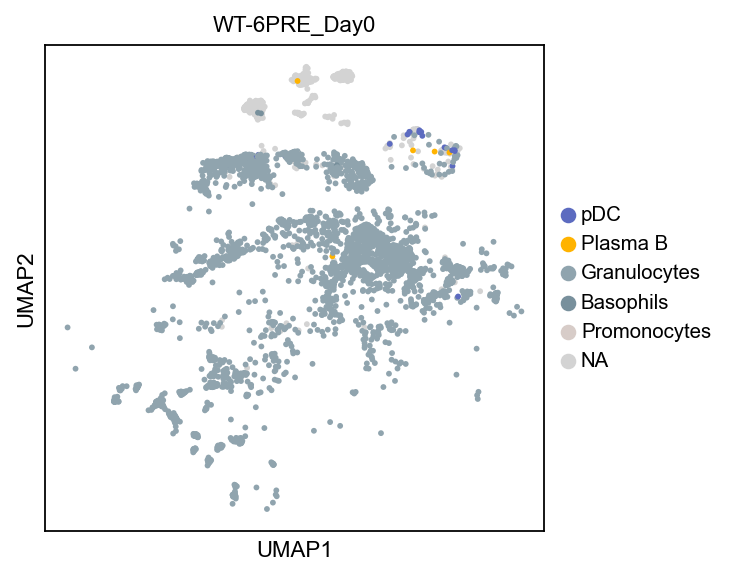

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


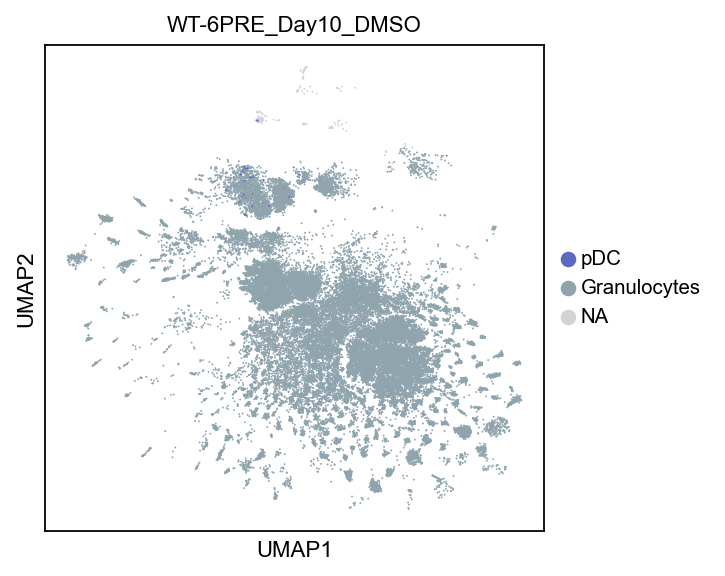

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


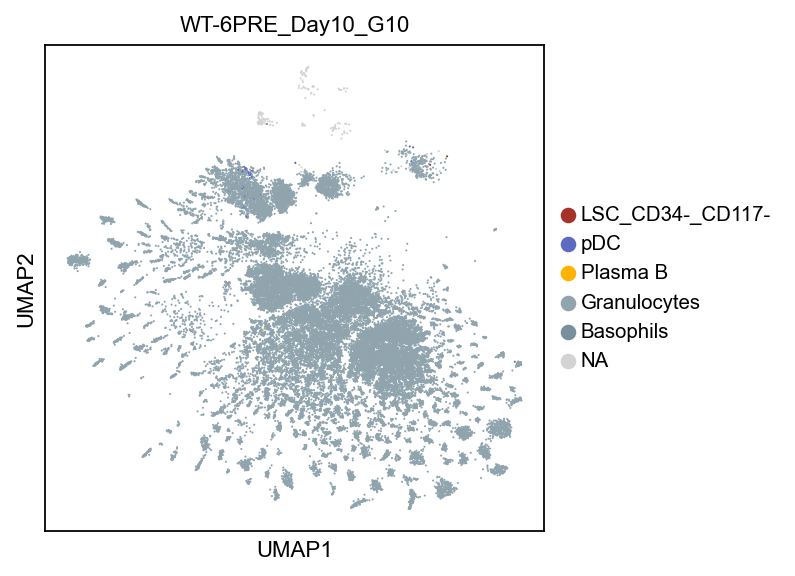

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


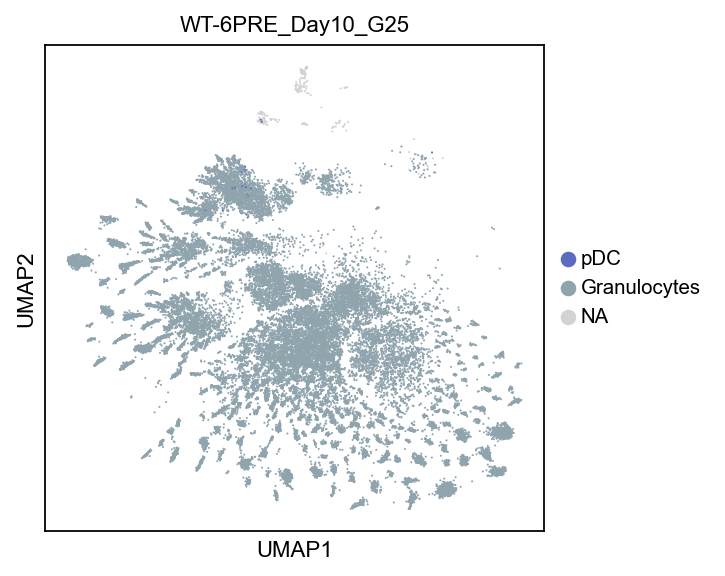

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


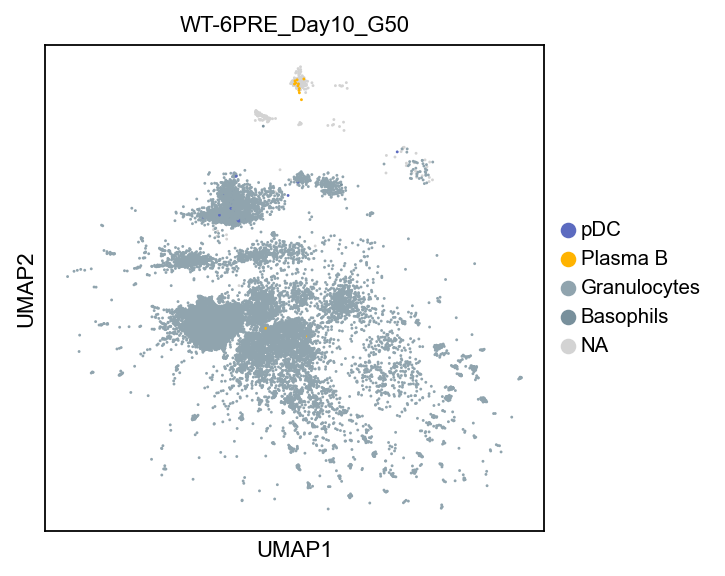

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


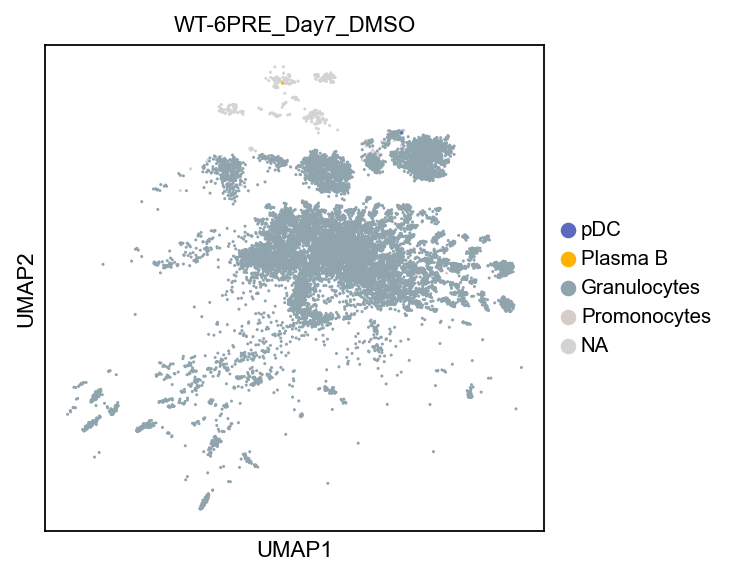

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


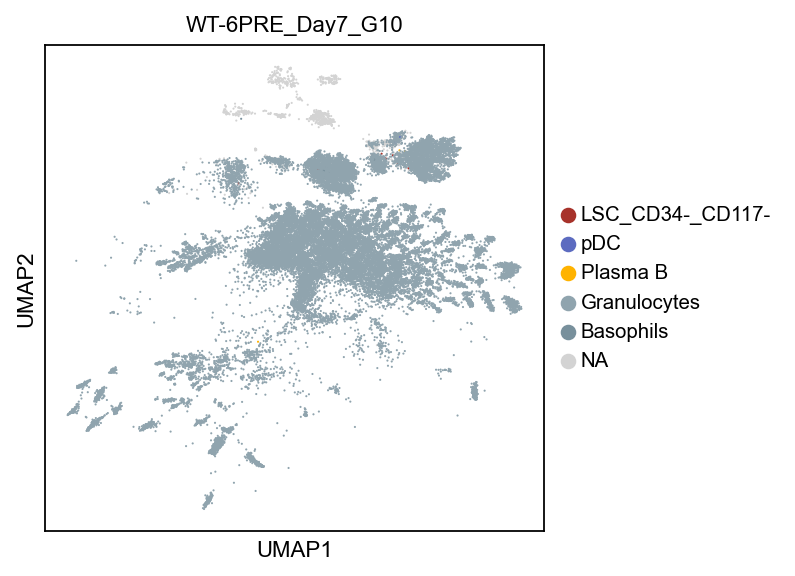

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


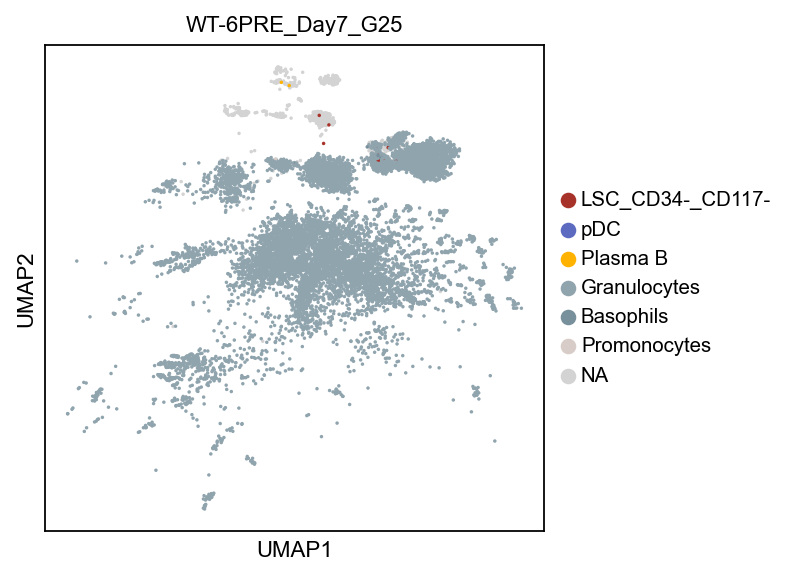

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\_scanpy_plot\umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


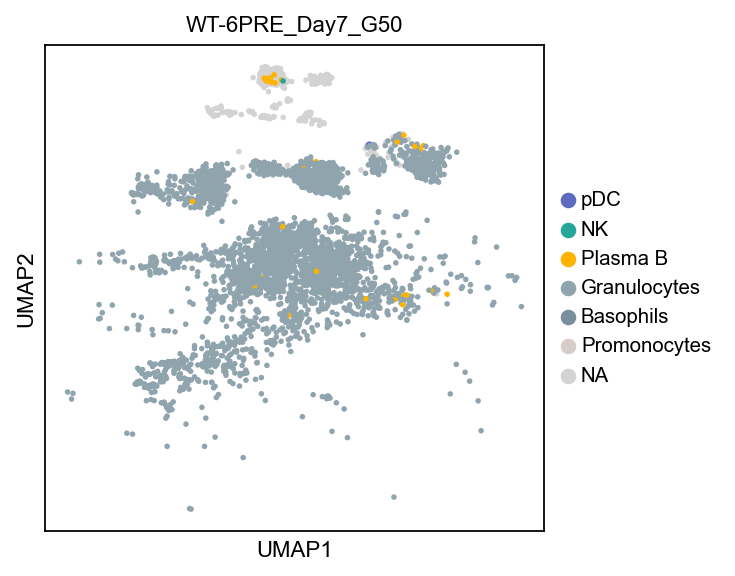

In [15]:
import numpy as np
import scyan

# Loop over each unique file in the 'file' column of the obs DataFrame for adata_WT6_PRE
for filename in np.unique(adata_WT6_PRE.obs["file"]):
    # Subset the data to include only the cells from the current file
    adata_one_file = adata_WT6_PRE[adata_WT6_PRE.obs["file"] == filename]
    
    # Plot the UMAP for the current subset of data
    scyan.plot.umap(adata_one_file, color="scyan_pop", title=filename, palette = color_palette)


# Time plot

C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\tools\biomarkers.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(groupby)
C:\Users\anush\AppData\Local\Programs\Python\Python39\lib\site-packages\scyan\plot\ratios.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

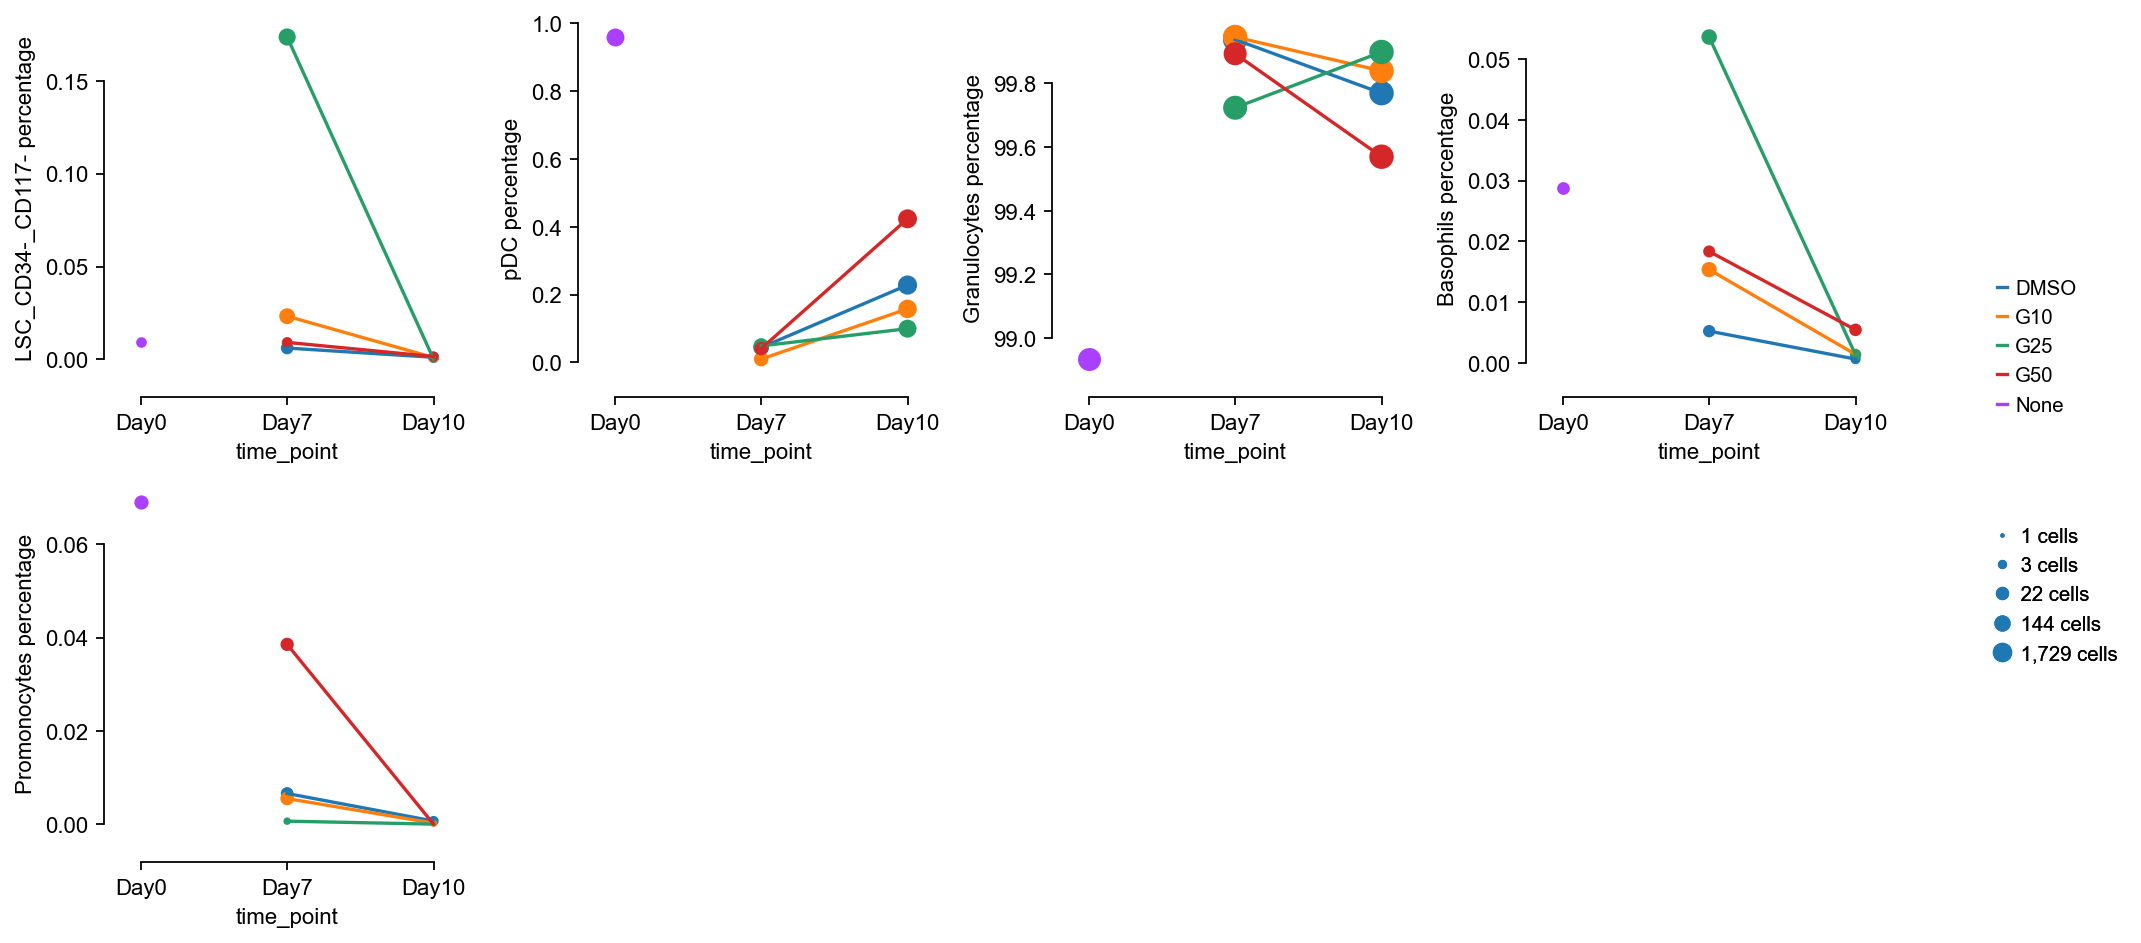

In [20]:
import scyan

# Define the myeloid cell populations of interest
myeloid_populations = [
    'Granulocytes',
    'Basophils',
    'CD11B+_Monocytes',
    'CD11B+_Monocytes*',
    'Promonocytes',
    'Mono_Myeloblastes_CD15+',
    'Mono_Myeloblastes_CD15-',
    'CMP',
    'MEP',
    'GMP',
    'Erythrocytes_CD45+',
    'Erythrocytes_CD45-',
    'LSC_CD34+_CD117+',
    'LSC_CD34+_CD117-',
    'LSC_CD34-_CD117+',
    'LSC_CD34-_CD117-',
    'pDC'
]

# Filter the AnnData object to include only the myeloid populations
adata_myeloid = adata_WT6_PRE[adata_WT6_PRE.obs['scyan_pop'].isin(myeloid_populations)]

# Plot population dynamics for myeloid cells
scyan.plot.pop_dynamics(
    adata_myeloid,        # Use the filtered AnnData object
    time_key="time_point",  # Column name for time points
    groupby="treatment",    # Column name for grouping
    key="scyan_pop"         # Column name for cell populations
)
